In [31]:
# Relevant Imports
from IPython.display import Image,HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', { 'width':1400, 'height': 768, 'scroll': True, })

{'width': 1400, 'height': 768, 'scroll': True}

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

from watertap.core.util.model_diagnostics.infeasible import *
from watertap.core.util.initialization import *

from pyomo.environ import (
    ConcreteModel,
    assert_optimal_termination
)
from pyomo.util.calc_var_value import calculate_variable_from_constraint as cvc

from idaes.core import FlowsheetBlock, UnitModelCostingBlock
from idaes.core.util.model_statistics import *

from watertap.core.solvers import get_solver

from watertap_contrib.reflo.costing import EnergyCosting
from watertap_contrib.reflo.analysis.case_studies.KBHDP.utils import *
from watertap_contrib.reflo.analysis.case_studies.KBHDP.data import *
from watertap_contrib.reflo.solar_models.surrogate.flat_plate.flat_plate_surrogate import (
    FlatPlateSurrogate,
)
from pyomo.environ import (
    value,
)

from idaes.core.util.model_statistics import degrees_of_freedom

from IPython.display import clear_output
from watertap_contrib.reflo.analysis.case_studies.KBHDP import *

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

cwd = %pwd

solver = get_solver()

In [33]:
def pv_plots(m):
    rd = build_results_dict(m)

    electricity_annual_model = list()
    electricity_annual_error = list()
    electricity_annual_error_rel = list()

    land_req_model = list()
    land_req_error = list()
    land_req_error_rel = list()

    for row in m.fs.pv.data.iterrows():
        m.fs.pv.design_size.fix(row[1].design_size)

        results = solver.solve(m, tee=False)
        assert_optimal_termination(results)
        electricity_annual_model.append(value(m.fs.pv.annual_energy))
        electricity_annual_error.append(value(m.fs.pv.annual_energy) - row[1].annual_energy)
        electricity_annual_error_rel.append(
            100
            * (value(m.fs.pv.annual_energy) - row[1].annual_energy)
            / row[1].annual_energy
        )
        land_req_model.append(value(m.fs.pv.land_req))
        land_req_error.append(value(m.fs.pv.land_req) - row[1].land_req)
        land_req_error_rel.append(
            100 * (value(m.fs.pv.land_req) - row[1].land_req) / row[1].land_req
        )
    #     rd = results_dict_append(m, rd)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
    axs[0][0].scatter(
        m.fs.pv.data.annual_energy,
        electricity_annual_model,
        marker="x",
    )
    axs[0][0].plot(
        [0, max(m.fs.pv.data.annual_energy)],
        [0, max(m.fs.pv.data.annual_energy)],
        color="black",
        linestyle="--",
    )
    axs[0][0].set(
        xlabel="Electrical Energy Generated (Data)",
        ylabel="Electrical Energy Generated (REFLO)",
    )

    axs[0][1].scatter(
        m.fs.pv.data.annual_energy, electricity_annual_error_rel, marker="x", color="k"
    )
    axs[0][1].plot(
        m.fs.pv.data.annual_energy,
        [0 for _ in m.fs.pv.data.annual_energy],
        color="black",
        linestyle="--",
    )
    axs[0][1].set(xlabel="Electrical Energy Generated (Data)", ylabel="% Error")

    axs[1][0].scatter(
        m.fs.pv.data.land_req,
        land_req_model,
        color="red",
        marker="x",
    )
    axs[1][0].plot(
        [0, max(m.fs.pv.data.land_req)],
        [0, max(m.fs.pv.data.land_req)],
        color="black",
        linestyle="--",
    )
    axs[1][0].set(xlabel="Land Required (Data)", ylabel="Land Required (WaterTAP)")

    axs[1][1].scatter(m.fs.pv.data.land_req, land_req_error_rel, marker="x", color="k")
    axs[1][1].plot(
        m.fs.pv.data.land_req,
        [0 for _ in m.fs.pv.data.land_req],
        color="black",
        linestyle="--",
    )
    axs[1][1].set(xlabel="Land Required (Data)", ylabel="% Error")
    fig.tight_layout()

In [34]:
def cst_plots(m):
    heat_annual_model = list()
    heat_annual_error = list()
    heat_annual_error_rel = list()

    electricity_annual_model = list()
    electricity_annual_error = list()
    electricity_annual_error_rel = list()

    for row in m.fs.cst.data.iterrows():

        m.fs.cst.heat_load.fix(row[1].heat_load)
        m.fs.cst.hours_storage.fix(row[1].hours_storage)
        m.fs.cst.initialize()

        try:
            results = solver.solve(m, tee=False)
        except:
            print_infeasible_constraints(m)
            assert False
        assert_optimal_termination(results)
        heat_annual_model.append(value(m.fs.cst.heat_annual))
        electricity_annual_model.append(value(m.fs.cst.electricity_annual))
        heat_annual_error.append(value(m.fs.cst.heat_annual) - row[1].heat_annual)
        electricity_annual_error.append(
            value(m.fs.cst.electricity_annual) - row[1].electricity_annual
        )
        heat_annual_error_rel.append(
            100 * (value(m.fs.cst.heat_annual) - row[1].heat_annual) / row[1].heat_annual
        )
        electricity_annual_error_rel.append(
            100
            * (value(m.fs.cst.electricity_annual) - row[1].electricity_annual)
            / row[1].electricity_annual
        )
#         rd = results_dict_append(m, rd)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
    axs[0][0].scatter(
        m.fs.cst.data.heat_annual,
        heat_annual_model,
        label="Heat Annual Model",
        marker="x",
    )
    axs[0][0].plot(
        [0, max(m.fs.cst.data.heat_annual)],
        [0, max(m.fs.cst.data.heat_annual)],
        color="black",
        linestyle="--",
    )
    axs[0][0].set(
        xlabel="Thermal Energy Generated (Data)",
        ylabel="Thermal Energy Generated (WaterTAP)",
    )

    axs[0][1].scatter(
        m.fs.cst.data.heat_annual, heat_annual_error_rel, marker="x", color="k"
    )
    axs[0][1].plot(
        m.fs.cst.data.heat_annual,
        [0 for _ in m.fs.cst.data.heat_annual],
        color="black",
        linestyle="--",
    )
    axs[0][1].set(xlabel="Annual Heat Energy (Data)", ylabel="% Error")
    axs[1][0].scatter(
        m.fs.cst.data.electricity_annual,
        electricity_annual_model,
        color="red",
        marker="x",
    )
    axs[1][0].plot(
        [0, max(m.fs.cst.data.electricity_annual)],
        [0, max(m.fs.cst.data.electricity_annual)],
        color="black",
        linestyle="--",
    )
    axs[1][0].set(
        xlabel="Electric Power Consumed (Data)", ylabel="Electric Power Consumed (WaterTAP)"
    )

    axs[1][1].scatter(
        m.fs.cst.data.electricity_annual,
        heat_annual_error_rel,
        label="Electricity Annual Model",
        marker="x",
        color="k",
    )
    axs[1][1].plot(
        m.fs.cst.data.electricity_annual,
        [0 for _ in m.fs.cst.data.electricity_annual],
        label="Electricity Annual Model",
        color="black",
        linestyle="--",
    )
    axs[1][1].set(xlabel="Electric Power Consumed (Data)", ylabel="% Error")
    fig.tight_layout()

Intro
- basic WaterTAP stuff
- touch on the compoenents of WaterTAP?
 
Figure of RPT1 flowsheet
 
RPT1
 
RPT1 - recovery sweep; get power demand
 
RPT1 - build PV surrogate based on power demand and RE fraction desired
 
Break for PV surrogate
 
Show Summary of this system
- recovery fraction, and final brine concentration
- cost metrics (LCOW, SEC)
- energy costs
- stacked plot
 
Figure of MLD flowsheet
 
80% recovery of RO
 
MLD - MD recovery sweep; get thermal power demand
 
MLD - build CST surrogate based on power demand
 
Break for CST surrogate
 
Show Summary of this system
- recovery fraction, and final brine concentration
- cost metrics (LCOW, SEC)
- energy costs
- stacked plot
 
Repeat for ZLD
 
Break for CST surrogate
 
Final Product would be summary of the three treatment trains and comparison

<h1>Demonstration of WaterTAP-REFLO Framework</h1>

<div 
    style=
     "max-height:800px; 
      overflow-y: auto;">
    
Contents:
<li>WaterTAP-REFLO framework</li>
<li>Treatment flowsheet workflow in WaterTAP-REFLO</li>
<ul>
    <li>Build, optimization and costing with a single unit model
    <li>Parameter sweeps and results
</ul>
    
<li>Build example analysis flowsheet energy</li>
<ul>
    <li>Build a complete treatment flowsheet
    <li>Build solar surrogate    
    <li>Integrate solar energy models
    <li>Parameter sweeps and results  
</ul>
<li>Comparative Analysis</li>
</div>

WaterTAP-REFLO Framework

<center><img src="figures/slides/slide14.jpeg" width=1000 height=1000>

The REFLOSystem Costing Package essential balances energy demand of the Water Treatment System with grid or renewable energy technologies
<center><img src="figures/slides/slide4.jpeg" width=1000 height=1000>

The levelized cost of treatment (LCOT) is determined by <br>
optimizing the water treatment system size and using the Treatment Costing package
<img src="figures/slides/slide1.jpeg" width=1200 height=1200>

The Energy System is sized based on the electricity/heat demand
and costed <br> using the Energy Costing package
<img src="figures/slides/slide2.jpeg" width=1200 height=1200>

The REFLOSystem Costing package connects the energy demand
of the Water Treatment System to the Energy System 
to optimize the for a LCOW with energy integration
<center><img src="figures/slides/slide3.jpeg" width=1000 height=1000>

Treatment flowsheet workflow in WaterTAP-REFLO

Water treatment train to be modeled
<left><img src="figures/slides/slide6.jpeg" width=1000 height=1000><left>

<div 
    style=
     "max-height:800px; 
      overflow-y: auto;">
    
Steps to building a flowsheet
1. Import relevant libraries
2. Add water property packages
3. Add and build the feed, product stream, treatment unit process
4. Connect treatment unit processes
5. Set feed stream conditions
6. Set unit process operating conditions
7. Scaling of parameters and constraints
8. Initialize model and propagate states to the next treatment unit
9. Add relevant operational constraints
10. Adding Costing to Water Treatment Flowsheet
    
Solve!
    

1. Import relevant libraries

In [9]:
from pyomo.environ import (
    ConcreteModel,
    value,
    Var,
    Constraint,
    Objective,
    NonNegativeReals,
    TransformationFactory,
    Block,
    units as pyunits,
)

#### Import functionality from pyomo, IDAES and WaterTAP
from pyomo.network import Arc
from idaes.core import FlowsheetBlock, UnitModelCostingBlock
from idaes.core.util.initialization import propagate_state as _prop_state
from watertap.core.util.initialization import *
from watertap.core.solvers import get_solver

#### Import feed and product blocks from IDAES
from idaes.models.unit_models import Product, Feed

#### Import water property package
from watertap.property_models.NaCl_prop_pack import NaClParameterBlock

#### Import treatment unit models from WaterTAP and WaterTAP-REFLO
from watertap.unit_models.pressure_changer import Pump
from watertap_contrib.reflo.analysis.case_studies.KBHDP.components.ro_system import *
from watertap_contrib.reflo.analysis.case_studies.KBHDP.components.deep_well_injection import *

#### Import input database costing package
from watertap_contrib.reflo.core import REFLODatabase
from watertap_contrib.reflo.costing import (
    TreatmentCosting,
)

#### Import debugging and scaling tools
from idaes.core.util.model_statistics import *
import idaes.core.util.scaling as iscale
from watertap.core.util.model_diagnostics.infeasible import *
from idaes.core.util.scaling import (
    constraint_scaling_transform,
    calculate_scaling_factors,
    set_scaling_factor,
)

2. Build the flowsheet and add water property packages

In [10]:
def build_system(RE=True):
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)

    #### Get unit model input data from a database
    m.db = REFLODatabase()

    ### Add water property package
    m.fs.RO_properties = NaClParameterBlock()

    return m


3. Add the feed, product stream, treatment unit process and build the unit processes

In [11]:
def build_treatment(m):
    #### Create a treatment block
    m.fs.treatment = Block()
    # Add feed, product and waste streams
    m.fs.treatment.feed = Feed(property_package=m.fs.RO_properties)
    m.fs.treatment.product = Product(property_package=m.fs.RO_properties)

    #### Add unit models for treatment and disposal
    m.fs.treatment.pump = Pump(property_package=m.fs.RO_properties)
    m.fs.treatment.RO = FlowsheetBlock(dynamic=False)
    m.fs.treatment.DWI = FlowsheetBlock(dynamic=False)

    ### Build unit models-> A build function is used to build a unit process and 
    #adds StateJunction or connectors  
    build_ro(m, m.fs.treatment.RO, prop_package=m.fs.RO_properties, number_of_stages=1)
    build_DWI(m, m.fs.treatment.DWI, prop_package=m.fs.RO_properties)

4. Define how the treatment unit processes are connected

In [12]:
def add_connections(m):
    #### Connect feed to pump
    m.fs.treatment.feed_to_pump = Arc(
        source=m.fs.treatment.feed.outlet,
        destination=m.fs.treatment.pump.inlet,
    )

    #### Connect pump to RO
    m.fs.treatment.pump_to_ro = Arc(
        source=m.fs.treatment.pump.outlet,
        destination=m.fs.treatment.RO.feed.inlet,
    )

    #### Connect RO to product
    m.fs.treatment.ro_to_product = Arc(
        source=m.fs.treatment.RO.product.outlet,
        destination=m.fs.treatment.product.inlet,
    )

    #### Connect RO to DWI
    m.fs.treatment.ro_to_dwi = Arc(
        source=m.fs.treatment.RO.disposal.outlet,
        destination=m.fs.treatment.DWI.unit.inlet,
    )

    TransformationFactory("network.expand_arcs").apply_to(m)


5. Set feed stream conditions

In [13]:
def set_operating_conditions(m):
    m.fs.treatment.feed.properties[0].flow_mass_phase_comp["Liq", "H2O"].fix(171.12)  
    m.fs.treatment.feed.properties[0].flow_mass_phase_comp["Liq", "NaCl"].fix(0.638) 
    m.fs.treatment.feed.properties[0].temperature.fix(298.15)  # 25 C
    m.fs.treatment.feed.properties[0].pressure.fix(101325)  # 101.325 kPa


6. Set unit process operating conditions

In [14]:
def set_pump_operating_conditions(m, pump_pressure=30e5):
    m.fs.treatment.pump.efficiency_pump.fix(0.8)  # 80% efficiency
    m.fs.treatment.pump.control_volume.properties_out[0].pressure.fix(pump_pressure)

In [15]:
def set_ro_operating_conditions(m,ro_mem_area=10000):
    #### RO membrane/module parameters
    mem_A = 4.2e-12  # membrane water permeability coefficient [m/s-Pa]
    mem_B = 3.5e-8  # membrane salt permeability coefficient [m/s]
    height = 1e-3  # channel height in membrane stage [m]
    spacer_porosity = 0.95  # spacer porosity in membrane stage [-]
    length = 7  # effective membrane width [m]
    width = 20000  # effective membrane width [m]
    pressure_atm = 101325  # atmospheric pressure [Pa]
    
    #### Fix RO design parameters for each stage
    for idx, stage in m.fs.treatment.RO.stage.items():
        stage.module.A_comp.fix(mem_A)
        stage.module.B_comp.fix(mem_B)
        stage.module.area.fix(ro_mem_area / idx)
        stage.module.feed_side.velocity[0, 0].fix(0.35)
        # stage.module.length.fix(length)
        stage.module.width.setub(width)
        stage.module.mixed_permeate[0].pressure.fix(pressure_atm)

        stage.module.feed_side.channel_height.fix(height)
        stage.module.feed_side.spacer_porosity.fix(spacer_porosity)

        stage.module.feed_side.friction_factor_darcy.setub(50)

        for e in stage.module.flux_mass_phase_comp:
            if e[-1] == "H2O":
                stage.module.flux_mass_phase_comp[e].setlb(1e-5)
                stage.module.flux_mass_phase_comp[e].setub(0.99)
    
    #### Create a variable that ties together each module area
    m.fs.treatment.RO.total_membrane_area = Var(
        initialize=10000,
        domain=NonNegativeReals,
        units=pyunits.m**2,
        doc="Total RO System Membrane Area",
    )

    m.fs.treatment.RO.eq_total_membrane_area = Constraint(
        expr=m.fs.treatment.RO.total_membrane_area
        == sum([stage.module.area for idx, stage in m.fs.treatment.RO.stage.items()])
    )

7. Scaling of parameters assists the solver to approach the optimal solution more easily

In [16]:
def add_ro_scaling(m, blk):
    ### Scale the property package
    m.fs.RO_properties.set_default_scaling(
        "flow_mass_phase_comp", 1, index=("Liq", "H2O")
    )
    m.fs.RO_properties.set_default_scaling(
        "flow_mass_phase_comp", 1e2, index=("Liq", "NaCl")
    )

    #### Set scaling factors for module parameters in each stage in the RO unit model
    for idx, stage in blk.stage.items():
        module = stage.module
        iscale.set_scaling_factor(module.area, 1e5)
        iscale.set_scaling_factor(module.feed_side.area, 1)
        iscale.set_scaling_factor(module.width, 1e4)
        set_scaling_factor(module.length, 1e1)
        set_scaling_factor(module.feed_side.N_Sh_comp, 1e-4)

        for e in module.feed_side.properties:
            set_scaling_factor(
                module.feed_side.properties[e].flow_mass_phase_comp["Liq", "NaCl"], 1
            )
            set_scaling_factor(module.feed_side.properties[e].dens_mass_phase["Liq"], 1)
            # set_scaling_factor(module.feed_side.properties[e].dens_mass_phase["Liq"], 1e3)
            set_scaling_factor(module.feed_side.properties[e].mass_frac_phase_comp["Liq", "NaCl"], 1e1)

        for temp_stream in [
            module.eq_permeate_isothermal,
            module.feed_side.eq_equal_temp_interface,
            module.feed_side.eq_feed_isothermal,
            module.eq_permeate_outlet_isothermal,
        ]:
            for e in temp_stream:
                constraint_scaling_transform(temp_stream[e], 1e-2)
            for pressure_stream in [
                module.eq_permeate_outlet_isobaric,
                module.feed_side.eq_equal_pressure_interface,
            ]:
                for e in pressure_stream:
                    constraint_scaling_transform(pressure_stream[e], 1e-5)
            for e in module.eq_pressure_drop:
                constraint_scaling_transform(module.eq_pressure_drop[e], 1e-7)

        for e in module.feed_side.eq_N_Sh_comp:
            if e[-1] == "NaCl":
                constraint_scaling_transform(module.feed_side.eq_N_Sh_comp[e], 1e-3)

        for e in module.feed_side.eq_friction_factor:
            constraint_scaling_transform(module.feed_side.eq_friction_factor[e], 1e-2)
        for e in module.feed_side.eq_dP_dx:
            constraint_scaling_transform(module.feed_side.eq_dP_dx[e], 1e-2)

        set_scaling_factor(module.mixed_permeate[0.0].dens_mass_phase["Liq"], 1)
        set_scaling_factor(module.mixed_permeate[0.0].flow_vol_phase["Liq"], 100)
        constraint_scaling_transform(
            module.mixed_permeate[0.0].eq_flow_vol_phase["Liq"], 100
        )

        for e in module.recovery_mass_phase_comp:
            if e[-1] == "H2O":
                set_scaling_factor(module.recovery_mass_phase_comp, 1e1)
    
    #### Uses the default scaling factors assigned to variables
    calculate_scaling_factors(m)

8. Initialize model and propagate states to the next treatment unit

In [17]:
def initialize_system(m):
    #### Initialize the feed stream
    m.fs.treatment.feed.initialize()

    #### Propagate state from feed to pump
    _prop_state(m.fs.treatment.feed_to_pump)

    #### Initialize the pump
    m.fs.treatment.pump.initialize()

    #### Propagate state from pump to RO
    _prop_state(m.fs.treatment.pump_to_ro)

    #### Initialize the RO unit model
    init_ro_system(m, m.fs.treatment.RO)

    #### Propagate state from RO to product
    _prop_state(m.fs.treatment.ro_to_product)

    #### Initialize the product stream
    m.fs.treatment.product.initialize()

    #### Propagate state from RO to DWI
    _prop_state(m.fs.treatment.ro_to_dwi)
    
    #### Initialize the DWI unit model
    m.fs.treatment.DWI.unit.initialize()

9. Add relevant operational constraints

In [18]:
# Add RO recovery constraint
# This constraint ensures that the water recovery from the RO unit is equal to the product flow rate
def add_ro_recovery_constraint(m, blk, ro_recovery):
    m.fs.treatment.ro_water_recovery = Var(
        initialize=ro_recovery,
        bounds=(0, 0.99),
        domain=NonNegativeReals,
        units=pyunits.dimensionless,
        doc="RO Water Recovery",
    )

    blk.eq_water_recovery = Constraint(
        expr=blk.feed.properties[0].flow_vol * m.fs.treatment.ro_water_recovery
        == blk.product.properties[0].flow_vol
    )

10. Adding Costing to Water Treatment Flowsheet. Here we can updates costs<br>such as the price of electricity and add a function to calculate the LCOW and the SEC

In [19]:
def add_costing(m,electricity_price=0.058):

    #### Add costing for treatment unit
    m.fs.treatment.costing = TreatmentCosting()

    #### Add pump costing
    m.fs.treatment.pump.costing = UnitModelCostingBlock(
        flowsheet_costing_block=m.fs.treatment.costing,
    )

    #### Add RO costing
    for stage in m.fs.treatment.RO.stage.values():
        stage.module.costing = UnitModelCostingBlock(
            flowsheet_costing_block=m.fs.treatment.costing
        )
    
    #### Add DWI costing
    add_DWI_costing(m.fs.treatment, m.fs.treatment.DWI, costing_blk=m.fs.treatment.costing)

    #### Update the electricity price for the analysis
    m.fs.treatment.costing.electricity_cost.fix(electricity_price)
    
    #### This function builds a constraint to aggregate electricity demand from all unit processes
    m.fs.treatment.costing.cost_process()
    
    #### LCOW function
    m.fs.treatment.costing.add_LCOW(m.fs.treatment.product.properties[0].flow_vol)
    
    ### SEC function
    product_m3h = pyunits.convert(
            m.fs.treatment.product.properties[0].flow_vol,
            to_units=pyunits.m**3 / pyunits.h,
        )
    m.fs.treatment.costing._add_flow_component_breakdowns(
        "electricity", "SEC_elec", product_m3h, period=pyunits.hr
    )
    
    #### Initialize the cost block
    m.fs.treatment.costing.initialize()

Build a single run function

In [20]:
def build_demo_sample_ro(ro_recovery=0.5):
    #### Build the system
    m = build_system()
    
    #### Build the treatment system
    build_treatment(m)
    
    #### Add connections between unit models
    add_connections(m)
    
    #### Set operating conditions
    set_operating_conditions(m)

    #### Set pump operating conditions
    set_pump_operating_conditions(m, pump_pressure=3e6)  # 300 kPa

    #### Set RO operating conditions
    set_ro_operating_conditions(m, ro_mem_area=10000)  # 100

    #### Add RO scaling factors
    add_ro_scaling(m, m.fs.treatment.RO)

    #### Add RO recovery constraint
    add_ro_recovery_constraint(m, m.fs.treatment.RO, ro_recovery=ro_recovery)

    #### Initialize the system
    initialize_system(m)

    print("Degree of freedom:", degrees_of_freedom(m))

    #### Add costing blocks
    add_costing(m, electricity_price=0.058)  # $0.058/kWh
    
    solver = get_solver()
    #### Solve the model
    results = solver.solve(m, tee=False)

    return m


Let's Solve!

In [21]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_sample_ro import *
from IPython.display import clear_output

m = build_demo_sample_ro() 

clear_output(wait=False)

print("Degrees of freedom:",degrees_of_freedom(m))
print("\nLCOW ($/m3):", m.fs.treatment.costing.LCOW())
print("Pump outlet pressure (psi):",pyunits.convert(m.fs.treatment.pump.control_volume.properties_out[0].pressure,to_units=pyunits.psi)())
print("Total membrane area (m2):", value(m.fs.treatment.RO.total_membrane_area))
print("RO Water Recovery:", value(m.fs.treatment.ro_water_recovery))
print("SEC electrical (kWh/m3):" )
m.fs.treatment.costing.SEC_elec_component.display()


Degrees of freedom: 0

LCOW ($/m3): 0.4251653159188776
Pump outlet pressure (psi): 435.11321319062745
Total membrane area (m2): 10000.0
RO Water Recovery: 0.5240608576225431
SEC electrical (kWh/m3):
SEC_elec_component : Size=1
    Key               : Value
    fs.treatment.pump : 1.9205486527152533


Optimization:\
For optimization we need to unfix parameters and set bounds for the solve

In [22]:
def set_ro_op_bounds(m, lb=100, ub=900):
    
    m.fs.treatment.pump.control_volume.properties_out[0].pressure.setlb(
        lb * pyunits.psi
    )
    m.fs.treatment.pump.control_volume.properties_out[0].pressure.setub(
        ub * pyunits.psi
    )

    for _, stage in m.fs.treatment.RO.stage.items():
        stage.module.width.setub(5000)
        stage.module.feed_side.velocity[0, 0].unfix()
        stage.module.feed_side.velocity[0, 1].setlb(0.0)
        stage.module.feed_side.K.setlb(1e-6)
        stage.module.feed_side.friction_factor_darcy.setub(50)
        stage.module.flux_mass_phase_comp.setub(1)
        stage.module.feed_side.cp_modulus.setub(10)
        stage.module.rejection_phase_comp.setlb(1e-4)
        stage.module.feed_side.N_Re.setlb(1)
        stage.module.recovery_mass_phase_comp.setlb(1e-7)

Run Optimization!

In [23]:
#### Build previous flowsheet
build_demo_sample_ro(ro_recovery=0.5)
print("LCOW ($/m3):", m.fs.treatment.costing.LCOW())

#### Fix membrane area and recovery
membrane_area=20000
m.fs.treatment.RO.total_membrane_area.fix(membrane_area)
m.fs.treatment.ro_water_recovery.fix(0.7)

#### Unfix parameters
m.fs.treatment.pump.control_volume.properties_out[0].pressure.unfix()
for _, stage in m.fs.treatment.RO.stage.items():
    stage.module.area.unfix()

#### Set bounds for the solve
set_ro_op_bounds(m)

#### Add objective function for optimization
m.fs.membrane_area_objective = Objective(expr=m.fs.treatment.costing.LCOW, sense="minimize")

#### Optimize!
solver = get_solver()
results = solver.solve(m, tee=False)

clear_output(wait=False)

print("Degrees of freedom:",degrees_of_freedom(m))
print("\nLCOW ($/m3):", m.fs.treatment.costing.LCOW())
print("Pump outlet pressure (psi):",pyunits.convert(m.fs.treatment.pump.control_volume.properties_out[0].pressure,to_units=pyunits.psi)())
print("Total membrane area (m2):", value(m.fs.treatment.RO.total_membrane_area))
print("RO Water Recovery:", value(m.fs.treatment.ro_water_recovery))
print("SEC electrical (kWh/m3):" )
m.fs.treatment.costing.SEC_elec_component.display()

Degrees of freedom: 1

LCOW ($/m3): 0.2970191197732617
Pump outlet pressure (psi): 329.87864642429304
Total membrane area (m2): 20000
RO Water Recovery: 0.7
SEC electrical (kWh/m3):
SEC_elec_component : Size=1
    Key               : Value
    fs.treatment.pump : 1.077930656396033


Run Sweep Across RO Recovery

In [24]:
def build_demo_sample_ro_sweep(ro_recovery=0.85):
    m = build_demo_sample_ro()

    m.fs.treatment.ro_water_recovery.fix(ro_recovery)
    m.fs.treatment.pump.control_volume.properties_out[0].pressure.unfix()

    m.fs.membrane_area_objective = Objective(
    expr=m.fs.treatment.costing.LCOW, sense="minimize"
    )

    solver = get_solver()
    results = solver.solve(m, tee=False)

    return m

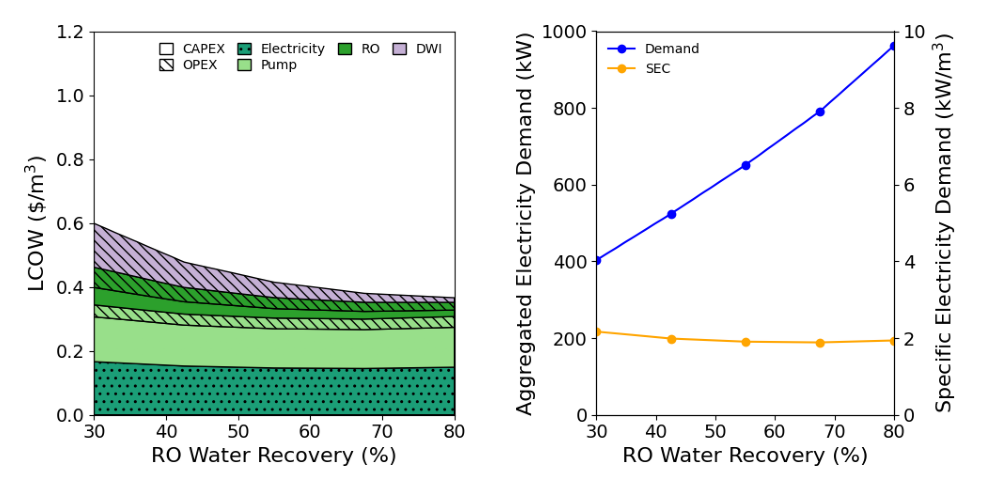

In [25]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_sample_ro import *

run_recovery_sweep(sweep_type="ro_water_recovery")
clear_output(wait=False)
plot_recovery_sweep(sweep_type="ro_water_recovery")

Build an analysis flowsheet with energy integration

<center><img src="figures/slides/slide7.jpeg" width=1000 height=1000><center>

Code Snippet

In [ ]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_kbhdp_ro import *

def demo1_grid_only(
        ro_recovery=0.8,
        heat_price=0.0,
        electricity_price=0.04989,
        dwi_lcow=0.58,
    ):
    '''This is modified for demonstration purposes'''
    
    #### Add a concrete flowsheet
    m = build_demo1_system()

    #### Add pretreatment and RO to the flowsheet. 
    #### This includes all the build, connections, initialization and solve
    m = build_kbhdp_ro(m,ro_recovery)

    #### Add product and deep well injection
    add_product(m)
    
    #### Treatment costing block
    add_treatment_costing(m,heat_price,electricity_price)
    
    #### Update DWI costing
    m.fs.treatment.costing.deep_well_injection.dwi_lcow.set_value(dwi_lcow)
    
    #### Set objective function
    m.fs.lcow_objective = Objective(expr=m.fs.treatment.costing.LCOW)

    results = solve(m)
    return m


RO Recovery Sweep

<img src="figures/results/kbhdp-ro-recovery-sweep.png" width=45% style="display:inline-block;"/> 
<img src="figures/results/kbhdp-ro-energy.png" width=45% style="display:inline-block;"/>

PySAM surrogates are built to meet the annual energy consumption of treatment system

<center><img src="figures/slides/slide5.jpeg" width=50% style="display:inline-block;"/> 
    
1. Weather file
2. Energy demand range of treatment system
3. Determine the inputs to PySAM model. Eg. System capacity, hours of storage, operating temperature etc.
4. Run PySAM for range of input
5. Create surrogate using outputs such as annual heat/electricity from PySAM in WaterTAP-REFLO

PV Surrogate: Users can decide the input to the surrogate model

<center><img src="figures/slides/slide13.jpeg" width="80%" style="display:inline-block;"/><center>

In [26]:
from watertap_contrib.reflo.solar_models.surrogate.pv import PVSurrogate
input_variables = {
    "labels": ["design_size"],
    "bounds": {"design_size": [1000, 10000]},
    "units": {"design_size": "kW"},
}
output_variables = {
    "labels": ["annual_energy", "land_req"],
    "units": {"annual_energy": "kWh", "land_req": "acre"},
}
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.costing = EnergyCosting()
m.fs.pv = PVSurrogate(
    dataset_filename="data/demo_pv.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=False,
)
clear_output(wait=False)

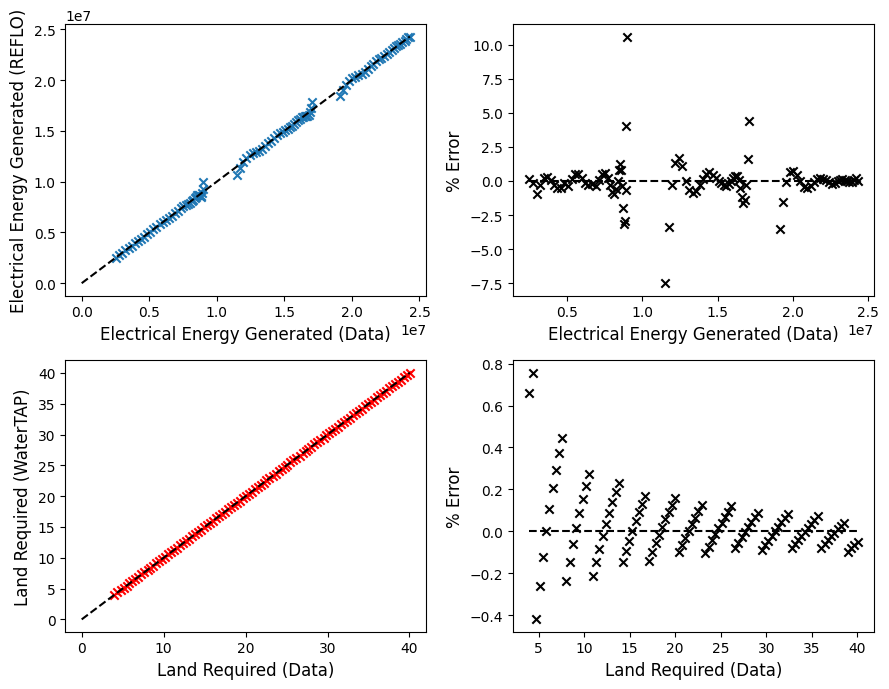

In [27]:
pv_plots(m)

Code Snippet with Integration of Solar Energy (PV)

In [28]:
def demo1_solar(
        ro_recovery=0.8,
        heat_price=0.0,
        electricity_price=0.04989,
        dwi_lcow=0.58,
        cost_per_watt_installed=1.6,
        frac_elec_from_grid = 0.5
    ):

    '''' This is modified for demonstration purposes'''

    ########## Treatment Block ##########
    m = build_demo1_system()
    m = build_kbhdp_ro(m,ro_recovery)
    add_product(m)
    add_treatment_costing(m,heat_price,electricity_price)
    
    #### Update DWI costing
    m.fs.treatment.costing.deep_well_injection.dwi_lcow.set_value(dwi_lcow)
    results = solve(m)

    ########## Energy Block ############

    #### Calculate required heat load and CST sizing
    m.fs.energy = Block()
    m.fs.energy.costing = EnergyCosting()
    
    #### Add PV unit model - Adds the PV surrogate unit model to flowsheet
    add_pv(m)
    
    #### Unfix PV design size and fix grid fraction
    add_electricity_energy_costing(m)
    m.fs.energy.pv.design_size.unfix()

    m.fs.energy.costing.cost_process()
    m.fs.energy.costing.initialize()
    
    
    #### Add REFLOSystem costing
    add_system_energy_costing(
        m, heat_price=heat_price, electricity_price=electricity_price)
    
    #### Fix fraction of electricity from the grid
    m.fs.costing.frac_elec_from_grid.fix(frac_elec_from_grid)

    results = solve(m)
     
    #### Update cost parameters to the PV surrogate
    m.fs.energy.costing.pv_surrogate.cost_per_watt_installed.fix(
        cost_per_watt_installed
    )

    m.fs.lcow_objective = Objective(expr=m.fs.costing.LCOT)

    results = solve(m)

Sweep across RO water recovery and Solar energy integration

<img src="figures/results/kbhdp-ro-solar-recovery-sweep.png" width=45% style="display:inline-block;"/>
<img src="figures/results/kbhdp-ro-solar-grid-sweep.png" width=45% style="display:inline-block;"/>

A sweep across DWI costs highlights its relative importance to other costs

<center><img src="figures/results/kbhdp-ro-dwi-sweep-2.png" width="50%"/> 

Minimum Liquid Discharge - Membrane distillation is included in the desalination step

<center><img src="figures/slides/slide9.jpeg" width=1000 height=1000><center>

Code Snippet of MLD flowsheet

In [3]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_kbhdp_mld import *
def demo2_mld_grid_only(
        ro_recovery=0.8,
        md_water_recovery=0.77,
        heat_price=0.00894,
        electricity_price=0.04989,
        dwi_lcow=0.58,
    ):

    '''' This is modified for demonstration purposes'''
    
    ########## Treatment Block ##########
    m = kbhdp_mld_ro(ro_recovery)

    md_flow = pyunits.convert(
        m.fs.treatment.RO.disposal.properties[0].flow_vol_phase["Liq"],
        to_units=pyunits.m**3 / pyunits.s,
    )
    md_conc = pyunits.convert(
        m.fs.treatment.RO.disposal.properties[0].conc_mass_phase_comp["Liq", "NaCl"],
        to_units=pyunits.g / pyunits.L,
    )

    #### Add MD
    m = add_mld_md(
        m, Q_md=md_flow(), Cin=md_conc(), md_water_recovery=md_water_recovery
    )

    #### Add product and deep well injection
    add_mld_product(m)
    results = solve(m)

    add_mld_treatment_costing(m, heat_price, electricity_price)

    #### Update DWI costing
    m.fs.treatment.costing.deep_well_injection.dwi_lcow.set_value(dwi_lcow)

    calculate_scaling_factors(m)
    results = solve(m)

    kbhdp_mld_md_reporting_variables(m)
    results = solve(m)

    return m

Sweep across MD water recovery

<img src="figures/results/kbhdp-mld-md-recovery-sweep.png" width="32%" style="display:inline-block;"/> 
<img src="figures/results/kbhdp-mld-elec.png" width="32%" style="display:inline-block;"/>
<img src="figures/results/kbhdp-mld-heat.png" width="32%" style="display:inline-block;"/>

In [ ]:
# CST surrogate
# Users can decide the input to the surrogate model-300C
# Net metering and 24h storage of thermal system
# Accuracy of surrogate

CST Surrogate: Users can decide the input to the surrogate model

<center><img src="figures/slides/slide12.jpeg" width="80%" style="display:inline-block;"/><center>

In [29]:
from watertap_contrib.reflo.solar_models.surrogate.trough.trough_surrogate import (
    TroughSurrogate,
)

input_bounds = dict(heat_load=[5, 25], hours_storage=[12, 24])
input_units = dict(heat_load="MW", hours_storage="hour")
input_variables = {
    "labels": ["heat_load", "hours_storage"],
    "bounds": input_bounds,
    "units": input_units,
}

output_units = dict(
    heat_annual_scaled="kWh",
    electricity_annual_scaled="kWh",
    total_aperture_area_scaled="m**2",
)
output_variables = {
    "labels": [
        "heat_annual_scaled",
        "electricity_annual_scaled",
        "total_aperture_area_scaled",
    ],
    "units": output_units,
}
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.cst = TroughSurrogate(
    dataset_filename="data/trough_demo_mld.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=True,)

clear_output(wait=False)

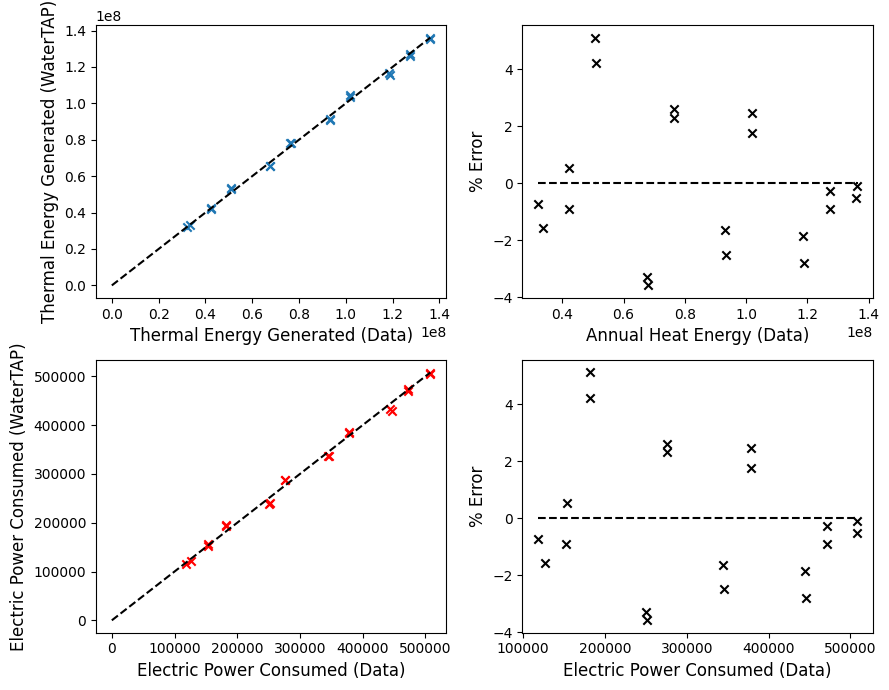

In [30]:
cst_plots(m)

Code Snippet of MLD flowsheet with Integration of Solar Energy (PV + CST)

In [6]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_kbhdp_mld import *

def demo2_mld_solar(
        ro_recovery=0.8,
        md_water_recovery=0.7,
        frac_heat_from_grid=0.5,
        frac_elec_from_grid=0.5,
        heat_price=0.00894,
        electricity_price=0.04989,
        cost_per_total_aperture_area=297,
        cost_per_storage_capital=62,
        cost_per_watt_installed=1.6,
        dwi_lcow=0.58,
    ):

    '''' This is modified for demonstration purposes'''
    ########## Treatment Block ##########
    m = kbhdp_mld_ro(ro_recovery)

    md_flow = pyunits.convert(
        m.fs.treatment.RO.disposal.properties[0].flow_vol_phase["Liq"],
        to_units=pyunits.m**3 / pyunits.s,
    )
    md_conc = pyunits.convert(
        m.fs.treatment.RO.disposal.properties[0].conc_mass_phase_comp["Liq", "NaCl"],
        to_units=pyunits.g / pyunits.L,
    )

    #### Add MD
    m = add_mld_md(
        m, Q_md=md_flow(), Cin=md_conc(), md_water_recovery=md_water_recovery
    )
    print(f"\nDOF after MD = {degrees_of_freedom(m)}")
    print("\n")

    #### Add product and deep well injection
    add_mld_product(m)
    results = solve(m)

    add_mld_treatment_costing(m, heat_price=0, electricity_price=0)
    
    #### Update DWI costing
    m.fs.treatment.costing.deep_well_injection.dwi_lcow.set_value(dwi_lcow)
    calculate_scaling_factors(m)

    results = solve(m)   

    ########## Energy Block ##########
    m.fs.energy = Block()
    m.fs.energy.costing = EnergyCosting()

    #### Add CST
    add_mld_cst(m)
    add_mld_heat_energy_costing(m)
    m.fs.energy.cst.unit.heat_load.unfix()

    calculate_scaling_factors(m)

    results = solve(m)

    #### Add PV
    add_mld_pv(m)
    add_mld_electricity_energy_costing(m)

    m.fs.energy.cst.unit.heat_load.unfix()
    m.fs.energy.pv.design_size.unfix()

    m.fs.energy.costing.cost_process()
    m.fs.energy.costing.initialize()

    add_mld_system_energy_costing(
        m, heat_price=heat_price, electricity_price=electricity_price
    )

    results = solve(m)

    #### CST heat load calculated
    m.fs.energy.cst.unit.heat_load.unfix()
    m.fs.costing.frac_heat_from_grid.fix(frac_heat_from_grid)

    m.fs.energy.pv.design_size.unfix()
    m.fs.costing.frac_elec_from_grid.fix(frac_elec_from_grid)

    calculate_scaling_factors(m)

    results = solve(m)

    #### Update cost parameters to the CST and PV surrogate
    m.fs.energy.costing.trough_surrogate.cost_per_total_aperture_area.fix(
        cost_per_total_aperture_area
    )
    m.fs.energy.costing.trough_surrogate.cost_per_storage_capital.fix(
        cost_per_storage_capital
    )
    m.fs.energy.costing.pv_surrogate.cost_per_watt_installed.fix(
        cost_per_watt_installed
    )

    ####
    m.fs.lcow_objective = Objective(expr=m.fs.costing.LCOT)

    calculate_scaling_factors(m)

    results = solve(m)

    kbhdp_mld_md_reporting_variables(m)

    return m


Sweep across MD water recovery with and without solar integration

<img src="figures/results/kbhdp-mld-md-recovery-sweep.png" width="45%" style="display:inline-block;">
<img src="figures/results/kbhdp-mld-solar-md-recovery-sweep.png" width="45%"style="display:inline-block;">

Sweep across solar integration fraction

<center><img src="figures/results/kbhdp-mld-solar-grid-sweep.png" width="50%">

Zero Liquid Discharge - Brine management step updated to crystallizer

<center><img src="figures/slides/slide8.jpeg" width=1000 height=1000><center>

Sweep across solar integration fraction

<img src="figures/results/kbhdp-zld-solar-grid-sweep.png" width="35%" style="display:inline-block;">
<img src="figures/results/kbhdp_zld_tornado_plots.png" width="55%" style="display:inline-block;">

Future Capabilities

Multiperiod PV-RO

<center><img src="figures/slides/slide10.jpeg" width="80%" style="display:inline-block;">

Multiperiod Thermal System

<center><img src="figures/slides/slide11.jpeg" width="90%" style="display:inline-block;">

1. Location specific remote treatment system optimization - Datacenters
2. Permian - brackish brine management
3. Flexible desalination - NAWI not very focused on renewable energy yet - Pricetaker model uses multiperiod framework and grid prices